In [34]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import datetime
import dateutil.relativedelta
from tqdm import tqdm

from datetime import datetime, timedelta
import seaborn as sns
from pylab import rcParams

In [35]:
TOP_10_Categories=['Mobile Phones']

# Store Selection 

In [36]:
TXN=pd.read_pickle('data/SDG_TXN_DF.pkl')
TXN=TXN[TXN['group']=='Mobile Phones']

TXN=TXN[['sku_id','store_code','sale_date','quantity']]
TXN=TXN.groupby(['sku_id','store_code'])['quantity'].sum().reset_index()
TXN=TXN.sort_values(['sku_id','quantity'],ascending=False)
TXN['CUMSUM'] = TXN.groupby(['sku_id'])['quantity'].apply(lambda x: x.cumsum())
TXN=TXN.merge(TXN.groupby(['sku_id'])['quantity'].sum().reset_index(),on=['sku_id'])
TXN['qty_share']=TXN['CUMSUM']/TXN['quantity_y']


Single_Store_SKU=TXN.groupby(['sku_id']).first()[['store_code','qty_share']].reset_index().sort_values(['qty_share'],ascending=False)

# Two Types
Single_Store_SKU=Single_Store_SKU[Single_Store_SKU['qty_share']>0.6]
Single_Store_SKU=Single_Store_SKU[['sku_id','store_code']]


Other_SKU=TXN[TXN['qty_share']<=0.85]
Other_SKU=Other_SKU[['sku_id','store_code']]

SKU_Store_Pair=Other_SKU.append(Single_Store_SKU)
SKU_Store_Pair.reset_index(inplace=True,drop=True)
SKU_Store_Pair

,sku_id,store_code
0,1088941002,1402
1,1088941002,1602
2,1088941002,1205
3,1088941002,1403
4,1088941002,1603
...,...,...
8663,1080736001,1402
8664,1000004002,1402
8665,1080319002,1401
8666,1070802003,1402


# Reading Data

In [37]:
TXN=pd.read_pickle('data/SDG_TXN_DF.pkl')
TXN=TXN[TXN['group']=='Mobile Phones']

PM=pd.read_pickle("data/SDG_PM_Blasted_DF.pkl")
PP=pd.read_pickle("data/SDG_Price_Point_DF.pkl")


# Trimming Data

In [38]:
TXN=TXN.merge(SKU_Store_Pair,on=['sku_id','store_code'])

In [39]:

# Product Master
PM=PM[ (PM['country_code']=='AE') & (PM['group'].isin(TOP_10_Categories))]
attribute_list=list(PM.columns[19:])+['quantity']


# Transaction 
TXN=TXN[(TXN['country_code']=='AE') & (TXN['group'].isin(TOP_10_Categories))]

#Price Point
PP=PP[(PP['country_code']=='AE') ]


# Bundling

In [40]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import preprocessing


from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from kneed import KneeLocator

import pickle

In [41]:
# Selecting Which Features to be used?

def get_attributes(group):
    print(group)
    PM_GROUP=PM[PM['group']==group]

    TXN_GROUP=TXN[TXN['group']==group]
    TXN_GROUP=TXN_GROUP.groupby(['sku_id'])['quantity'].sum().reset_index()
    TXN_GROUP['sku_id']=TXN_GROUP['sku_id'].astype(str)


    PM_GROUP=PM_GROUP.merge(TXN_GROUP,on=['sku_id'],how='left')

    PM_GROUP=PM_GROUP[attribute_list]


    y_train=PM_GROUP['quantity']
    X_train=PM_GROUP
    del X_train['quantity']

    Non_Null_Attr=X_train.count().reset_index()
    X_train=X_train[list(Non_Null_Attr['index'][Non_Null_Attr[0]>0])]


    for xt_col in X_train.columns:
        print("        "+xt_col)
        le = preprocessing.LabelEncoder()
        X_train[xt_col]=X_train[xt_col].astype(str)
        X_train[xt_col] = eval(f"le.fit_transform(X_train['{xt_col}'].values)")

    X_train=X_train.fillna(-1)    
    y_train=y_train.fillna(0)


    clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=3, min_samples_leaf=5)
    clf_gini.fit(X_train, y_train)

    ATTR_DF=pd.DataFrame(X_train.columns)
    ATTR_DF.columns=['Attribute']
    ATTR_DF['GINI']=list(clf_gini.feature_importances_)
    ATTR_DF['group']=group
    
    
    return ATTR_DF.sort_values(['GINI'])

Selected_Attributes=pd.DataFrame()
for x in TOP_10_Categories:
    Selected_Attributes=Selected_Attributes.append(get_attributes(x))
Selected_Attributes    

Mobile Phones
        Color
        Screen Size
        Internal Memory
        RAM
        Connectivity
        Rear / Front Camera
        Resolution
        Battery Capacity
        CPU
        OS Version
        Range indoors | outdoors
        Ringer Melodies
        Standby time
        Talk time


,Attribute,GINI,group
2,Internal Memory,0.000000,Mobile Phones
3,RAM,0.000000,Mobile Phones
4,Connectivity,0.000000,Mobile Phones
5,Rear / Front Camera,0.000000,Mobile Phones
6,Resolution,0.000000,Mobile Phones
8,CPU,0.000000,Mobile Phones
10,Range indoors | outdoors,0.000000,Mobile Phones
11,Ringer Melodies,0.000000,Mobile Phones
12,Standby time,0.000000,Mobile Phones
13,Talk time,0.000000,Mobile Phones


Mobile Phones


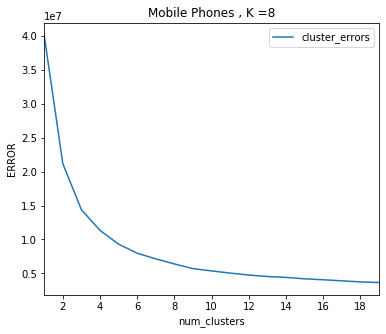

,K_Clusters,Group
0,8,Mobile Phones


In [42]:
# Finding How many Clusters are needed for each category? 
#Adding 3 additional cluster on top of best K cluster (derived statistically). This makes sure that we are able to guarantee capture of higher order of variation with in the category


def Find_Best_CLusters_K(group):
    print(group)
    PM_GROUP=PM[PM['group']==group]
    PM_GROUP=PM_GROUP[list(Selected_Attributes['Attribute'][Selected_Attributes['group']==group])]



    for xt_col in PM_GROUP.columns:
        le = preprocessing.LabelEncoder()
        PM_GROUP[xt_col]=PM_GROUP[xt_col].astype(str)
        PM_GROUP[xt_col] = eval(f"le.fit_transform(PM_GROUP['{xt_col}'].values)")


    data_transformed=PM_GROUP

    
    cluster_range = range(1, 20) #test for cluster sizes 1 to 10
    cluster_errors = [] #create array to hold errors

    for num_clusters in cluster_range:
        clusters = KMeans(num_clusters )
        clusters.fit(data_transformed)
        cluster_errors.append( clusters.inertia_ )

    clusters_df = pd.DataFrame({"cluster_errors": cluster_errors, "num_clusters": cluster_range})

    elbow = KneeLocator(clusters_df.num_clusters.values, clusters_df.cluster_errors.values, S=1.0, curve='convex', direction='decreasing')

    
    clusters_df.set_index(['num_clusters']).plot()
    plt.ylabel("ERROR")
    plt.title(f"{group} , K ={elbow.knee+3}")
    plt.show()
    
    ret_df=pd.DataFrame([3+(elbow.knee)],columns=['K_Clusters'])
    ret_df['Group']=group
    return ret_df

Best_Cluster_K=pd.DataFrame()
for x in TOP_10_Categories:
    Best_Cluster_K=Best_Cluster_K.append(Find_Best_CLusters_K(x))
    print("\n\n")
Best_Cluster_K    
    

In [43]:
## UnSupervised Learning - Clustering : Marking SKUs, Saving Model

def create_clusters_and_save(group):
    PM_GROUP=PM[PM['group']==group]
    PM_SKU=PM_GROUP[['sku_id']]


    PM_GROUP=PM_GROUP[list(Selected_Attributes['Attribute'][Selected_Attributes['group']==group])]

    PM_GROUP=PM_GROUP.fillna('')

    K_Cluster=Best_Cluster_K[Best_Cluster_K['Group']==group]['K_Clusters'].values[0]

    km = KModes(n_clusters=K_Cluster, init='Huang', n_init=11, verbose=1)
    km_mdl=km.fit(PM_GROUP)

    PM_SKU['cluster']=list(km_mdl.labels_)
    PM_SKU['group']=group
    
    filename=f"cluster_{group}.pkl"
    pickle.dump(km_mdl, open(filename, 'wb'))
    return PM_SKU


Group_SKU_Cluster_DF=pd.DataFrame()
for x in TOP_10_Categories:
    print(x)
    Group_SKU_Cluster_DF=Group_SKU_Cluster_DF.append(create_clusters_and_save(x))
    print("\n\n")
    

Mobile Phones
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 986, cost: 10652.0
Run 1, iteration: 2/100, moves: 269, cost: 10629.0
Run 1, iteration: 3/100, moves: 3, cost: 10629.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 693, cost: 10606.0
Run 2, iteration: 2/100, moves: 133, cost: 10606.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 768, cost: 10701.0
Run 3, iteration: 2/100, moves: 207, cost: 10638.0
Run 3, iteration: 3/100, moves: 18, cost: 10638.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 535, cost: 10790.0
Run 4, iteration: 2/100, moves: 113, cost: 10683.0
Run 4, iteration: 3/100, moves: 119, cost: 10672.0
Run 4, iteration: 4/100, moves: 0, cost: 10672.0
Init: initializing centroids
Init: initializing clusters
St

In [44]:
Group_SKU_Cluster_DF

,sku_id,cluster,group
5487,1000438,1,Mobile Phones
5488,1000439,1,Mobile Phones
5489,1000450,1,Mobile Phones
5490,1000451,1,Mobile Phones
5491,1000453,1,Mobile Phones
...,...,...,...
200581,1126008,5,Mobile Phones
200582,1126009,5,Mobile Phones
201695,200107,0,Mobile Phones
201696,200110,0,Mobile Phones


In [45]:
#Finding Product Launch
Product_Launch=TXN.groupby(['sku_id'])['sale_date'].min().reset_index().sort_values(['sale_date'])
Product_Launch['days_since_launch']=(pd.to_datetime(TXN['sale_date'].max())-pd.to_datetime(Product_Launch['sale_date'])).dt.days
Product_Launch=Product_Launch[Product_Launch['days_since_launch']<=90]

In [44]:
#Finding Price Elasticity : Discount vs Ros

In [46]:
interested_sku_id=list(Product_Launch['sku_id'])

MRP=PP.groupby(['sku_id'])['retail_base_price'].max().reset_index().rename(columns={'retail_base_price':'MRP'})
TXN=TXN.merge(MRP,on=['sku_id'])
TXN['discount']=TXN['MRP']-TXN['revenue']

TXN['discount_percent']=TXN['discount']/TXN['MRP']
TXN['discount_percent']=TXN['discount_percent'].round(2)

def myround(x, prec=2, base=.05):
    return round(base * round(float(x)/base),prec)


TXN['discount_percent']=TXN['discount_percent'].apply(myround)


In [47]:
TXN[['sale_date','sku_id','revenue','MRP','discount','discount_percent']].head()

,sale_date,sku_id,revenue,MRP,discount,discount_percent
0,2019-08-21,1130219,3809.0,3808.57,-0.43,0.0
1,2019-08-24,1130219,3809.0,3808.57,-0.43,0.0
2,2019-08-08,1130219,3809.0,3808.57,-0.43,0.0
3,2019-08-24,1130219,3809.0,3808.57,-0.43,0.0
4,2019-08-07,1130219,3809.0,3808.57,-0.43,0.0


In [106]:
#Discount Sensitivity

In [48]:
from scipy.stats import linregress

In [49]:
intrested_discount_bracket=[0.00,0.05,0.10,0.15,0.20,0.25,0.30]
discount_sensitivity=TXN.groupby(['sku_id','discount_percent']).aggregate({"quantity":['sum'], 
              "sale_date":['nunique']}).reset_index()
discount_sensitivity.columns=['sku_id','discount_percent','quantity','days']
discount_sensitivity['quantity_per_day']=discount_sensitivity['quantity']/discount_sensitivity['days']
discount_sensitivity=discount_sensitivity[discount_sensitivity['discount_percent'].isin(intrested_discount_bracket)]

discount_sensitivity=discount_sensitivity.pivot_table(
index=['sku_id'],
columns=['discount_percent'],
values=['quantity_per_day']
).reset_index()
discount_sensitivity.columns=discount_sensitivity.columns.get_level_values(1)
discount_sensitivity=discount_sensitivity.fillna(0)
discount_sensitivity=discount_sensitivity.rename(columns={'':'sku_id'})
discount_sensitivity=discount_sensitivity.set_index(['sku_id'])

In [51]:
slope_list=[]
for sku_value in list(discount_sensitivity.index):
    a = list(discount_sensitivity.columns)
    b = list(discount_sensitivity.loc[sku_value])
    from scipy.stats import linregress
    slope_list=slope_list+[linregress(a, b)[0]]

In [52]:
discount_sensitivity['discount_sensitivity']=slope_list

In [53]:
discount_sensitivity

#reading Guide:
#-ve slope - Increase in discount might not lead to effective increase in quatity per day
#+ve slope - Increase in discount might lead to effective increase in quatity per day
#Magintude : Shows the degree of impact on qty_per_day

discount_percent,0.0,0.05,0.1,0.15,0.2,0.25,0.3,discount_sensitivity
sku_id,,,,,,,,
1000242,3.346154,0.000000,0.0,0.00,0.0,0.0,0.0,-7.170330
1000249,0.000000,2.000000,0.0,0.00,0.0,0.0,0.0,-2.857143
1000269,1.000000,0.000000,0.0,0.00,0.0,0.0,0.0,-2.142857
1000272,2.000000,2.000000,3.0,0.00,2.0,0.0,2.0,-3.571429
1000273,0.000000,0.000000,0.0,0.00,0.0,0.0,2.0,4.285714
...,...,...,...,...,...,...,...,...
1085110001,1.813953,0.000000,0.0,1.25,0.0,0.0,1.0,-1.744186
1087947001,4.448276,0.000000,0.0,0.00,0.0,0.0,0.0,-9.532020
1087947002,3.442308,0.000000,0.0,0.00,0.0,0.0,0.0,-7.376374


In [54]:
discount_sensitivity=discount_sensitivity.reset_index()
ros=TXN.groupby(['sku_id'])['quantity'].sum().reset_index()
discount_sensitivity=discount_sensitivity.merge(ros,on=['sku_id'])

In [55]:
discount_sensitivity=discount_sensitivity.rename(columns={'quantity':'ros'})
discount_sensitivity

,sku_id,0.0,0.05,0.1,0.15,0.2,0.25,0.3,discount_sensitivity,ros
0,1000242,3.346154,0.000000,0.0,0.00,0.0,0.0,0.0,-7.170330,349
1,1000249,0.000000,2.000000,0.0,0.00,0.0,0.0,0.0,-2.857143,2
2,1000269,1.000000,0.000000,0.0,0.00,0.0,0.0,0.0,-2.142857,5
3,1000272,2.000000,2.000000,3.0,0.00,2.0,0.0,2.0,-3.571429,26
4,1000273,0.000000,0.000000,0.0,0.00,0.0,0.0,2.0,4.285714,8
...,...,...,...,...,...,...,...,...,...,...
891,1085110001,1.813953,0.000000,0.0,1.25,0.0,0.0,1.0,-1.744186,91
892,1087947001,4.448276,0.000000,0.0,0.00,0.0,0.0,0.0,-9.532020,1170
893,1087947002,3.442308,0.000000,0.0,0.00,0.0,0.0,0.0,-7.376374,763
894,1088941001,3.794393,2.600000,0.0,0.00,0.0,0.0,0.0,-11.845127,596


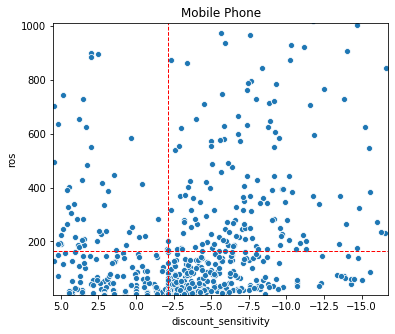

In [56]:


plot_df_qdr=discount_sensitivity
sns.scatterplot(x='discount_sensitivity',y='ros',data=plot_df_qdr)

#Line
l_ros=plot_df_qdr['ros'].quantile(np.arange(.1,1,.1))[0.6]
l_df=plot_df_qdr['discount_sensitivity'].quantile(np.arange(.1,1,.1))[0.6] 

plt.axvline(x=l_df,color='red',linestyle="--",linewidth=1)
plt.axhline(y=l_ros,color='red',linestyle="--",linewidth=1)


# Limits
ylim_min=plot_df_qdr['discount_sensitivity'].quantile(np.arange(.01,1,.01))[0.05]     
ylim_max=plot_df_qdr['discount_sensitivity'].quantile(np.arange(.01,1,.01))[0.9]

xlim_min=plot_df_qdr['ros'].quantile(np.arange(.01,1,.01))[0.05]     
xlim_max=plot_df_qdr['ros'].quantile(np.arange(.01,1,.01))[0.9]


plt.ylim(xlim_min,xlim_max)
plt.xlim(ylim_min,ylim_max)


#Title
plt.title('Mobile Phone')    
plt.gca().invert_xaxis()
rcParams['figure.figsize'] = 6, 5

plt.show()

In [57]:

# Marking Quadrants
plot_df_qdr=plot_df_qdr.fillna(0)
plot_df_qdr['quandrant']=''

plot_df_qdr['quandrant'][
    (plot_df_qdr['ros']>=l_ros) &
    (plot_df_qdr['discount_sensitivity']<=l_df)
]='H-Ros, L-Dis_Sen : Q1'

#####

plot_df_qdr['quandrant'][
    (plot_df_qdr['ros']>=l_ros) &
    (plot_df_qdr['discount_sensitivity']>=l_df)
]='H-Ros, H-Dis_Sen : Q2'

#####

plot_df_qdr['quandrant'][
    (plot_df_qdr['ros']<=l_ros) &
    (plot_df_qdr['discount_sensitivity']>=l_df)
]='L-Ros, H-Dis_Sen : Q3'

#####

plot_df_qdr['quandrant'][
    (plot_df_qdr['ros']<=l_ros) &
    (plot_df_qdr['discount_sensitivity']<=l_df)
]='L-Ros, L-Dis_Sen : Q4'

quandrant_list=list(plot_df_qdr["quandrant"].str.split(":", n = 1, expand = True)[0])
quandrant_meaning_list=list(plot_df_qdr["quandrant"].str.split(":", n = 1, expand = True)[1])
plot_df_qdr['quandrant_list']=quandrant_meaning_list
plot_df_qdr['quandrant_meaning']=quandrant_list     
quadrant=plot_df_qdr[['sku_id','quandrant_list']]

In [58]:
q1 = right top = less discount sensitive - more ros     - limit discount(Discount Optimse), if allowed increase price 
q2 = right bottom = less discount sensitive - less ros  - limit discount(Discount Optimse) + promotion / recommendation
q3 = left bottom = more discount sensitive - less ros   - Discount Optimse + Bundling
q4 = left top = more discount sensitive - more ros      - Discount Optimse (Find optimum discount)

SyntaxError: invalid syntax (<ipython-input-58-61377ed86cb8>, line 1)

In [139]:
# Discount Optimse - Building a Mchine Leaning Model to predict ros wrt to given discount 

#Feature Engineering

Analytical dataset will be created at sku_id, date level

Indp Variable Types:
    * Discount Of the Product as of that date
    * Events and Promotion - did that date have any event or promotion
    * Product info 
      - cluster it belongs to

Dep Variable  - Rate of Sale

In [59]:
FE_Target=TXN.groupby(['sku_id','sale_date'])['quantity'].sum().reset_index()
display(FE_Target)
FE_IND_1=TXN.groupby(['sku_id','sale_date'])['discount_percent'].min().reset_index()
FE_IND_1['sale_week']=pd.to_datetime(FE_IND_1['sale_date']).dt.week
FE_IND_1['sale_year']=pd.to_datetime(FE_IND_1['sale_date']).dt.year
FE_IND_1['sale_month']=pd.to_datetime(FE_IND_1['sale_date']).dt.month



display(FE_IND_1)

,sku_id,sale_date,quantity
0,1000241,2018-12-08,1
1,1000242,2018-06-01,6
2,1000242,2018-06-02,5
3,1000242,2018-06-03,3
4,1000242,2018-06-04,3
...,...,...,...
68676,1088941002,2019-08-24,2
68677,1088941002,2019-08-25,2
68678,1088941002,2019-08-27,1
68679,1088941002,2019-08-28,5


,sku_id,sale_date,discount_percent,sale_week,sale_year,sale_month
0,1000241,2018-12-08,0.90,49,2018,12
1,1000242,2018-06-01,0.00,22,2018,6
2,1000242,2018-06-02,0.00,22,2018,6
3,1000242,2018-06-03,0.00,22,2018,6
4,1000242,2018-06-04,0.00,23,2018,6
...,...,...,...,...,...,...
68676,1088941002,2019-08-24,0.05,34,2019,8
68677,1088941002,2019-08-25,0.05,34,2019,8
68678,1088941002,2019-08-27,0.05,35,2019,8
68679,1088941002,2019-08-28,0.05,35,2019,8


In [60]:
sale_date_df=pd.DataFrame(TXN['sale_date'].unique()).rename(columns={0:'sale_date'}).sort_values(['sale_date']).reset_index(drop=True)


def add_event_flag(df,Date_from_list,Date_To_list,Event):
    
    df[Event]=0
    for i in range(0,len(Date_from_list)):
        D_From=Date_from_list[i]
        D_To=Date_To_list[i]

        query_string=f" (df['sale_date']>='{Date_from_list[i]}') & (df['sale_date']<='{Date_To_list[i]}') & "
        exe_str=f"df['{Event}'][{query_string[0:len(query_string)-3]}]=1"
        exec(exe_str) 
    return df

def add_date(Date_from_list,Date_To_list,Event):
    
    # Adding Seasonal Effect
    df=add_event_flag(sale_date_df,Date_from_list,Date_To_list,Event)
    
    
    # Adding Pre Effect
    Date_From_pre_list=[]
    Date_To_pre_list=[]
    for i in range(0,len(Date_from_list)):
        Date_To_pre_list = Date_To_pre_list  + [ (pd.to_datetime(Date_from_list[i]) - timedelta(days=14)).strftime('%Y-%m-%d') ]
        Date_From_pre_list  = Date_From_pre_list + [ (pd.to_datetime(Date_from_list[i]) - timedelta(days=1)).strftime('%Y-%m-%d')]

                
    df=add_event_flag(df,Date_To_pre_list,Date_From_pre_list,Event+"_Pre") 
    
    # Adding Post Effect
    for i in range(0,len(Date_from_list)):
        Date_from_list[i] = (pd.to_datetime(Date_To_list[i]) + timedelta(days=1)).strftime('%Y-%m-%d')
        Date_To_list[i] = (pd.to_datetime(Date_To_list[i]) + timedelta(days=14)).strftime('%Y-%m-%d')

    df=add_event_flag(df,Date_from_list,Date_To_list,Event+"_Post")        
    return df


Date_from_list,Date_To_list,Event=(['2018-05-10','2019-05-05'],['2018-06-16','2019-06-08'],'Ramzan') #FESTIVAL
sale_date_df=add_date(Date_from_list,Date_To_list,Event)

Date_from_list,Date_To_list,Event=(['2018-10-02','2019-09-24'],['2018-10-06','2019-09-28'],'Gitex') # EXPO
sale_date_df=add_date(Date_from_list,Date_To_list,Event)

Date_from_list,Date_To_list,Event=(['2018-12-28','2019-12-29'],['2019-02-03','2020-02-03'],'DSF') #DUBAI EXPO
sale_date_df=add_date(Date_from_list,Date_To_list,Event)

Date_from_list,Date_To_list,Event=(['2018-08-19','2019-08-12'],['2018-08-23','2019-08-15'],'Bakid') #FESTIVAL
sale_date_df=add_date(Date_from_list,Date_To_list,Event)


In [61]:
FE_IND_2=sale_date_df

In [62]:
FE_IND_3=Group_SKU_Cluster_DF[['sku_id','cluster']]

In [63]:
FE_IND_1['sku_id']=FE_IND_1['sku_id'].astype(str)
FE_IND_3['sku_id']=FE_IND_3['sku_id'].astype(str)
FE_Target['sku_id']=FE_Target['sku_id'].astype(str)

In [64]:
FE=FE_IND_1.merge(FE_IND_3,on=['sku_id']).merge(FE_IND_2,on=['sale_date'])

In [65]:
AD=FE.merge(FE_Target,on=['sku_id','sale_date'])

In [66]:
AD.columns

Index(['sku_id', 'sale_date', 'discount_percent', 'sale_week', 'sale_year', 'sale_month', 'cluster', 'Ramzan', 'Ramzan_Pre', 'Ramzan_Post', 'Gitex', 'Gitex_Pre', 'Gitex_Post', 'DSF', 'DSF_Pre', 'DSF_Post', 'Bakid', 'Bakid_Pre', 'Bakid_Post', 'quantity'], dtype='object')

In [67]:
AD=AD.groupby(
['sale_week','sale_year','sale_month', 'discount_percent', 'cluster', 'Ramzan', 
 'Ramzan_Pre', 'Ramzan_Post', 'Gitex', 'Gitex_Pre', 
 'Gitex_Post', 'DSF', 'DSF_Pre', 'DSF_Post', 'Bakid', 
 'Bakid_Pre', 'Bakid_Post'])['quantity'].sum().reset_index()

AD=AD[AD['discount_percent'].isin(intrested_discount_bracket)]

In [68]:
scenario_generator=AD[['sale_year','sale_month','sale_week']].drop_duplicates()
target_week=scenario_generator.sort_values(['sale_year','sale_month','sale_week']).tail(1)

In [304]:
AD.head()

,sale_week,sale_year,sale_month,discount_percent,cluster,Ramzan,Ramzan_Pre,Ramzan_Post,Gitex,Gitex_Pre,Gitex_Post,DSF,DSF_Pre,DSF_Post,Bakid,Bakid_Pre,Bakid_Post,quantity
11,1,2019,1,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,100
12,1,2019,1,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,54
13,1,2019,1,0.0,2,0,0,0,0,0,0,1,0,0,0,0,0,4
14,1,2019,1,0.0,3,0,0,0,0,0,0,1,0,0,0,0,0,139
15,1,2019,1,0.0,4,0,0,0,0,0,0,1,0,0,0,0,0,139


In [69]:
target_week['sale_year'].values[0]

2019

In [70]:

#MDL Develope
AD_TRAIN=AD[~(
    
    (AD['sale_year']==target_week['sale_year'].values[0]) &
    (AD['sale_month']==target_week['sale_month'].values[0]) &
    (AD['sale_week']==target_week['sale_week'].values[0]))  ]


In [71]:
column_list=list(AD_TRAIN.columns)
column_list.remove('quantity')

In [72]:
X_train=AD_TRAIN[column_list]
y_train=AD_TRAIN['quantity']
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=30, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [73]:
ATTR_DF=pd.DataFrame(X_train.columns)
ATTR_DF.columns=['Attribute']
ATTR_DF['GINI']=list(clf_gini.feature_importances_)

In [385]:
#Scenario Generate

In [74]:

#MDL Develope
AD_SCENARIO=FE[(
    
    (FE['sale_year']==target_week['sale_year'].values[0]) &
    (FE['sale_month']==target_week['sale_month'].values[0]) &
    (FE['sale_week']==target_week['sale_week'].values[0]))  ]

AD_SCENARIO=AD_SCENARIO[['sku_id','sale_week','sale_year','sale_month',
             'cluster','Ramzan',
             'Ramzan_Pre', 'Ramzan_Post', 'Gitex', 'Gitex_Pre', 
             'Gitex_Post', 'DSF', 'DSF_Pre', 'DSF_Post', 'Bakid', 
             'Bakid_Pre', 'Bakid_Post'
            ]].drop_duplicates()

In [75]:
AD_SCENARIO.reset_index(drop=True,inplace=True)

In [76]:
SCENARIO_DF=pd.DataFrame()
for i in tqdm(range(0,len(AD_SCENARIO))):
    for dp in intrested_discount_bracket:
        tmp=pd.DataFrame(AD_SCENARIO.loc[i]).T
        tmp['discount_percent']=dp
        SCENARIO_DF=SCENARIO_DF.append(tmp)

100%|██████████| 191/191 [00:06<00:00, 28.08it/s]


In [77]:
X_SCN_DF=SCENARIO_DF[column_list]
SCENARIO_DF['predicted_quantity']=clf_gini.predict(X_SCN_DF)

In [78]:
SCENARIO_DF[['sku_id','discount_percent','predicted_quantity']].head()

,sku_id,discount_percent,predicted_quantity
0,1063361,0.00,13
0,1063361,0.05,8
0,1063361,0.10,8
0,1063361,0.15,8
0,1063361,0.20,8


In [79]:
max_pred_qty=SCENARIO_DF.groupby(['sku_id'])['predicted_quantity'].max().reset_index()
SCENARIO_DF=SCENARIO_DF.merge(max_pred_qty,on=['sku_id','predicted_quantity'])
SCENARIO_DF=SCENARIO_DF.sort_values(['sku_id','discount_percent'],ascending=[False,True])

In [80]:
Best_Discount=SCENARIO_DF.groupby(['sku_id']).first()

In [81]:
REcommendation=Best_Discount.reset_index()[['sku_id','discount_percent']]

In [82]:
REcommendation['sku_id']=REcommendation['sku_id'].astype(str)
quadrant['sku_id']=quadrant['sku_id'].astype(str)

REcommendation=REcommendation.merge(quadrant,on=['sku_id'])
REcommendation['quandrant_list']=REcommendation['quandrant_list'].apply(lambda x: x.strip())

In [83]:
REcommendation['Recommendation_Bundle']=0
REcommendation['Recommendation_Promotion']=0

REcommendation['Recommendation_Bundle'][REcommendation['quandrant_list']=='Q2']=1
REcommendation['Recommendation_Promotion'][REcommendation['quandrant_list']=='Q4']=1
del REcommendation['quandrant_list']

In [87]:
REcommendation=REcommendation.merge(max_pred_qty,on=['sku_id'])
REcommendation=REcommendation.rename(columns={'predicted_quantity':'minimum_guarentee_quantity_sale'})
REcommendation=REcommendation.merge(PM[['sku_id','short_description','brand']],on=['sku_id'])

In [88]:
REcommendation

,sku_id,discount_percent,Recommendation_Bundle,Recommendation_Promotion,minimum_guarentee_quantity_sale,minimum_guarentee_quantity_sale,short_description,brand
0,1000001004,0.25,0,1,14,14,Nokia 3 TA1032 4G Dual Sim Smartphone 16GB Sil...,Nokia
1,1000072001,0.25,0,0,14,14,Samsung Galaxy Grand Prime Pro ( J2 - 2018 ) 4...,Samsung
2,1000084002,0.20,0,0,14,14,Apple iPhone 7 32GB Black,Apple
3,1000084003,0.20,0,0,14,14,Apple iPhone 7 32GB Silver,Apple
4,1000084004,0.20,0,0,14,14,Apple iPhone 7 32GB Gold,Apple
5,1000086001,0.20,0,0,14,14,Apple iPhone 8 64GB Space Grey,Apple
6,1000086002,0.15,0,0,15,15,Apple iPhone 8 64GB Silver,Apple
7,1000086003,0.20,0,0,14,14,Apple iPhone 8 64GB Gold,Apple
8,1000089001,0.15,1,0,15,15,Apple iPhone X 64GB Silver,Apple
9,1000089003,0.20,0,0,14,14,Apple iPhone X 256GB Silver,Apple
